In [2]:
!pip install -q numpy pandas scipy matplotlib



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from __future__ import annotations
import os
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Optional, Tuple
from dataclasses import dataclass
from scipy.optimize import minimize
import matplotlib.pyplot as plt

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 50)

_EPS = 1e-12


In [ ]:
# directory, RV and returns (windows)
RV_DIR = r"C:\Users\Rickey\Documents\GitHub\rvforecasting\data\rv (dachengxiu)"
RETURNS_CSV = r"C:\Users\Rickey\Documents\GitHub\rvforecasting\data\returns (crsp).csv"

# tickers
TICKERS = ["SPY","XLB","XLE","XLF","XLI","XLK","XLP","XLU","XLV","XLY"]

# Realized measure choice & assumptions
REALIZED_TYPE = "QMLE-Trade"  # default to trade
ANNUALIZED_INPUT = True       # Dacheng Xiu 'Volatility' is annualized

# Rolling estimation config
MIN_WARMUP_OBS = 750          # ~3y warm-up before first monthly forecast
TRADING_DAYS = 252            # for de-annualizing volatility


In [ ]:
# data loaders (keep annualized vol for evaluation)
def load_returns_csv(path_returns: str, use_column: str = "RETX") -> pd.DataFrame:
    import pandas as pd
    df = pd.read_csv(path_returns)
    df["Date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
    df["PN"] = pd.to_numeric(df["PERMNO"], errors="coerce")
    df[use_column] = pd.to_numeric(df[use_column], errors="coerce")
    out = (df.loc[:, ["PN","Date",use_column]]
             .rename(columns={use_column:"ret"})
             .dropna())
    out["ret"] = out["ret"].astype(float).clip(-0.99, 5.0)
    return out.sort_values(["PN","Date"]).reset_index(drop=True)

def load_realized_vol_folder(folder: str, tickers, realized_type: str = "QMLE-Trade") -> pd.DataFrame:
    import os, pandas as pd
    frames = []
    for t in tickers:
        path = os.path.join(folder, f"{t}.csv")
        if not os.path.exists(path):
            alt = os.path.join(folder, f"{t.upper()}.csv")
            if os.path.exists(alt):
                path = alt
            else:
                raise FileNotFoundError(f"Missing realized vol file for {t}: {path}")
        dfi = pd.read_csv(path)
        if "Type" in dfi.columns:
            dfi = dfi[dfi["Type"] == realized_type].copy()
        need = {"PN","Date","Volatility"}
        if not need.issubset(dfi.columns):
            raise ValueError(f"{t}: expected {need}, got {set(dfi.columns)}")
        dfi["Date"] = pd.to_datetime(dfi["Date"], errors="coerce")
        dfi["PN"] = pd.to_numeric(dfi["PN"], errors="coerce")
        dfi["Volatility"] = pd.to_numeric(dfi["Volatility"], errors="coerce")
        dfi["ticker"] = t
        frames.append(dfi[["ticker","PN","Date","Volatility"]].dropna())
    rv = pd.concat(frames, ignore_index=True)
    return rv.sort_values(["ticker","PN","Date"]).reset_index(drop=True)

def build_panel(rv_df: pd.DataFrame, returns_df: pd.DataFrame,
                annualized_vol: bool = True, trading_days: int = 252) -> pd.DataFrame:
    """
    Returns columns:
      - 'ticker','PN','Date'
      - 'ret'   : daily return (ex-div)
      - 'x'     : daily realized variance
      - 'vol_ann': annualized realized volatility (as in your HAR)
    """
    import numpy as np
    merged = rv_df.merge(returns_df, on=["PN","Date"], how="inner").copy()
    vol_ann = merged["Volatility"].astype(float)             # same units as HAR
    vol_daily = vol_ann / np.sqrt(float(trading_days)) if annualized_vol else vol_ann
    x = (vol_daily ** 2).astype(float)                        # daily variance for RGARCH
    merged["x"] = x
    merged["ret"] = merged["ret"].astype(float)
    merged["vol_ann"] = vol_ann.astype(float)
    merged = merged.dropna(subset=["x","ret","vol_ann"])
    return (merged.loc[:, ["ticker","PN","Date","ret","x","vol_ann"]]
                 .sort_values(["ticker","Date"])
                 .reset_index(drop=True))


In [ ]:
# load & merge data into the working panel

ret_df = load_returns_csv(RETURNS_CSV, use_column="RETX")
rv_df  = load_realized_vol_folder(RV_DIR, TICKERS, realized_type=REALIZED_TYPE)
panel  = build_panel(rv_df, ret_df, annualized_vol=ANNUALIZED_INPUT, trading_days=TRADING_DAYS)

print("Returns:", ret_df.shape, "| RV:", rv_df.shape, "| Panel:", panel.shape)
panel.head(3)


Returns: (66223, 3) | RV: (63963, 4) | Panel: (63510, 6)


,ticker,PN,Date,ret,x,vol_ann
0,SPY,84398,1996-01-02,0.010673,0.000078,0.140261
1,SPY,84398,1996-01-03,0.002766,0.000027,0.082399
2,SPY,84398,1996-01-04,-0.009529,0.000177,0.211454


In [ ]:
# realised GARCH(1,1) with quadratic leverage (log-linear)

@dataclass
class RGarchResult:
    params: Dict[str, float]
    loglike: float
    s: pd.Series          # log h_t
    h: pd.Series          # h_t = variance
    z: pd.Series          # standardized returns
    meas_resid: pd.Series # measurement residual u_t
    converged: bool
    message: str


class RealizedGARCH:
    """
    Log-linear RealGARCH(1,1) with quadratic leverage:
      r_t = sqrt(h_t)*z_t,  z_t ~ N(0,1)
      s_t = log(h_t) = omega + beta*s_{t-1} + gamma*log(x_{t-1})
      y_t = log(x_t) = xi + phi*s_t + tau1*z_t + tau2*(z_t**2 - 1) + u_t,  u_t ~ N(0, sigma_u^2)

    Pass x as daily realized VARIANCE. If you pass daily realized VOLATILITY instead,
    set x_is_volatility=True.
    """
    def __init__(self, x_is_volatility: bool = False, penalize_rho: bool = True):
        self.x_is_volatility = x_is_volatility
        self.penalize_rho = penalize_rho
        self._fit_res: Optional[RGarchResult] = None

    @staticmethod
    def _prep(rx: pd.DataFrame) -> Tuple[pd.Series, pd.Series]:
        assert {"ret","x"}.issubset(rx.columns), "rx must have columns ['ret','x']"
        return rx["ret"].astype(float).copy(), rx["x"].astype(float).copy()

    def _neg_qll(self, theta: np.ndarray, r: np.ndarray, x: np.ndarray) -> float:
        # theta = [omega, beta, gamma, xi, phi, tau1, tau2, log_sigma_u, s0]
        omega, beta, gamma, xi, phi, tau1, tau2, log_su, s0 = theta
        su2 = np.exp(2.0 * log_su) + _EPS
        T = len(r)

        x_var = x**2 if self.x_is_volatility else x
        x_var = np.maximum(x_var, _EPS)
        y = np.log(x_var)

        s = np.empty(T); h = np.empty(T); z = np.empty(T)
        ll = 0.0
        for t in range(T):
            s[t] = (omega + beta * (s0 if t == 0 else s[t-1]) + gamma * (y[0] if t == 0 else y[t-1]))
            h[t] = np.exp(s[t])
            z[t] = r[t] / np.sqrt(h[t] + _EPS)
            meas = y[t] - (xi + phi * s[t] + tau1 * z[t] + tau2 * (z[t]**2 - 1.0))
            ll += -0.5 * (np.log(h[t] + _EPS) + z[t]**2) - 0.5 * (np.log(su2) + (meas**2) / su2)

        # Stability cue on rho = beta + phi*gamma
        if self.penalize_rho:
            rho = beta + phi * gamma
            if abs(rho) >= 0.999:
                ll -= 1e6 * (abs(rho) - 0.999)**2

        return -ll

    def fit(self, rx: pd.DataFrame, init: Optional[Dict[str, float]] = None, verbose: bool = False) -> RGarchResult:
        r, x = self._prep(rx)
        base = float(np.mean(x**2 if self.x_is_volatility else x))
        s0 = float(np.log(max(float(np.var(r)), base, _EPS)))

        guess = dict(
            omega=0.0, beta=0.9, gamma=0.05,
            xi=0.0,   phi=0.9,
            tau1=0.0, tau2=0.0,
            log_sigma_u=np.log(0.2),
            s0=s0,
        )
        if init: guess.update(init)
        theta0 = np.array([guess[k] for k in ["omega","beta","gamma","xi","phi","tau1","tau2","log_sigma_u","s0"]])

        bounds = [
            (None, None),     # omega
            (-0.999, 0.999),  # beta
            (-0.999, 0.999),  # gamma
            (None, None),     # xi
            (0.0, 2.5),       # phi (positive in practice; allow >1 generously)
            (None, None),     # tau1
            (None, None),     # tau2
            (np.log(1e-4), np.log(10.0)),  # log_sigma_u
            (np.log(1e-12), np.log(1e+3))  # s0
        ]

        opt = minimize(self._neg_qll, theta0, args=(r.values, x.values),
                       method="L-BFGS-B", bounds=bounds, options=dict(maxiter=500, disp=verbose))

        omega, beta, gamma, xi, phi, tau1, tau2, log_su, s0 = opt.x

        # filtered states for output
        x_var = (x.values**2 if self.x_is_volatility else x.values).clip(_EPS)
        y = np.log(x_var)
        T = len(r)
        s = np.empty(T); h = np.empty(T); z = np.empty(T); m = np.empty(T)
        for t in range(T):
            s[t] = (omega + beta * (s0 if t == 0 else s[t-1]) + gamma * (y[0] if t == 0 else y[t-1]))
            h[t] = np.exp(s[t])
            z[t] = r.values[t] / np.sqrt(h[t] + _EPS)
            m[t] = y[t] - (xi + phi * s[t] + tau1 * z[t] + tau2 * (z[t]**2 - 1.0))

        res = RGarchResult(
            params=dict(omega=omega, beta=beta, gamma=gamma, xi=xi, phi=phi,
                        tau1=tau1, tau2=tau2, sigma_u=np.exp(log_su), s0=s0),
            loglike=float(-opt.fun),
            s=pd.Series(s, index=rx.index, name="log_h"),
            h=pd.Series(h, index=rx.index, name="h"),
            z=pd.Series(z, index=rx.index, name="z"),
            meas_resid=pd.Series(m, index=rx.index, name="u"),
            converged=bool(opt.success),
            message=str(opt.message)
        )
        self._fit_res = res
        return res

    def forecast_one_step(self, rx: pd.DataFrame) -> float:
        """
        One-step-ahead variance forecast h_{T+1|T} using last (s_T, x_T).
        """
        assert self._fit_res is not None, "Call fit() first."
        p = self._fit_res.params
        last_s = self._fit_res.s.iloc[-1]
        x_t = rx["x"].iloc[-1]
        x_var = (x_t**2) if self.x_is_volatility else x_t
        y_t = np.log(max(x_var, _EPS))
        s_next = p["omega"] + p["beta"] * last_s + p["gamma"] * y_t
        return float(np.exp(s_next))


In [ ]:
# static 60/40 split forecasting 

def rgarch_static_split_oos(panel: pd.DataFrame, split_ratio: float = 0.60, td_annualize: int = 252) -> pd.DataFrame:
    """
    For each ticker:
      1) keep dates with both returns and realized measures;
      2) single fit on the first `split_ratio` fraction of the sample;
      3) recursively produce one-step-ahead forecasts over the remaining 1-split fraction;
      4) output both variance and annualized volatility forecasts.

    Returns columns: ['ticker','Date','h_fore1','sigma_fore1_ann','vol_ann','set']
      - 'h_fore1'          : variance forecast (daily)
      - 'sigma_fore1_ann'  : annualized volatility forecast (for apples-to-apples with HAR Target)
      - 'vol_ann'          : actual annualized realized volatility (your HAR 'RV_daily')
      - 'set'              : 'train' or 'test' flag matching your HAR split
    """
    import numpy as np, pandas as pd
    out = []
    for tkr, g in panel.groupby("ticker"):
        g = g.sort_values("Date").set_index("Date")[["ret","x","vol_ann"]].copy()
        n = len(g)
        if n < 300:
            continue
        split_idx = int(np.floor(split_ratio * n))
        train_rx = g.iloc[:split_idx][["ret","x"]]
        test_rx  = g.iloc[split_idx:][["ret","x"]]
        if len(train_rx) < 100:
            continue

        model = RealizedGARCH(x_is_volatility=False)
        fit_res = model.fit(train_rx)

        # Prepare recursive one-step-ahead forecasts across the test set
        om, be, ga = fit_res.params["omega"], fit_res.params["beta"], fit_res.params["gamma"]
        prev_s = float(fit_res.s.iloc[-1])           # last filtered state from train
        prev_x = float(train_rx["x"].iloc[-1])       # last realized variance from train

        h_fore = pd.Series(index=test_rx.index, dtype=float)
        for dt, row in test_rx.iterrows():
            # forecast for dt given info up to previous day
            s_next = om + be * prev_s + ga * np.log(max(prev_x, 1e-12))
            h_fore.loc[dt] = float(np.exp(s_next))
            # update recursion with realized x_t for next step
            prev_s = s_next
            prev_x = float(row["x"])

        # Convert variance forecast to annualized volatility for comparison to HAR
        sigma_fore1_ann = np.sqrt(h_fore) * np.sqrt(td_annualize)

        df_train = (g.iloc[:split_idx]
                      .assign(h_fore1=np.nan,
                              sigma_fore1_ann=np.nan,
                              set="train"))
        df_test  = (g.iloc[split_idx:]
                      .assign(h_fore1=h_fore.values,
                              sigma_fore1_ann=sigma_fore1_ann.values,
                              set="test"))
        both = (pd.concat([df_train, df_test])
                  .assign(ticker=tkr)
                  .reset_index()
                  .rename(columns={"index":"Date"}))

        out.append(both[["ticker","Date","h_fore1","sigma_fore1_ann","vol_ann","set"]])

    return (pd.concat(out, ignore_index=True)
              .sort_values(["ticker","Date"])
              .reset_index(drop=True))


In [ ]:
# metrics (MSE, R^2, MAE on annualized vol)

def score(y_hat, y, metric):
    import numpy as np
    if metric == "MSE":
        return float(np.mean((y_hat - y) ** 2))
    elif metric == "R_squared":
        ss_res = np.sum((y - y_hat) ** 2)
        ss_tot = np.sum((y - np.average(y)) ** 2)
        return float(1 - ss_res / ss_tot)
    elif metric == "MAE":
        return float(np.mean(np.abs(y - y_hat)))
    else:
        raise ValueError("Unknown metric")


In [ ]:
# run: load, build panel, fit once (60/40)

# 1) Load
ret_df = load_returns_csv(RETURNS_CSV, use_column="RETX")
rv_df  = load_realized_vol_folder(RV_DIR, TICKERS, realized_type=REALIZED_TYPE)
panel  = build_panel(rv_df, ret_df, annualized_vol=ANNUALIZED_INPUT, trading_days=TRADING_DAYS)

# 2) Forecast with a single estimation per ticker
rg_oos = rgarch_static_split_oos(panel, split_ratio=0.60, td_annualize=TRADING_DAYS)

# 3) Apples-to-apples metrics on the TEST set (annualized volatility)
scores = []
for tkr, g in rg_oos[rg_oos["set"]=="test"].groupby("ticker"):
    y_true = g["vol_ann"].values.astype(float)            # HAR 'RV_daily'
    y_hat  = g["sigma_fore1_ann"].values.astype(float)    # RGARCH annualized vol forecast
    scores.append({
        "ticker": tkr,
        "MSE": score(y_h  at, y_true, "MSE"),
        "R_squared": score(y_hat, y_true, "R_squared"),
        "MAE": score(y_hat, y_true, "MAE"),
        "n_test": len(g)
    })
pd.DataFrame(scores).sort_values("ticker").reset_index(drop=True)


C:\Users\Rickey\AppData\Local\Temp\ipykernel_14220\1754643033.py:49: RuntimeWarning: overflow encountered in exp
  h[t] = np.exp(s[t])
C:\Users\Rickey\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\Rickey\AppData\Local\Temp\ipykernel_14220\1754643033.py:49: RuntimeWarning: overflow encountered in exp
  h[t] = np.exp(s[t])
C:\Users\Rickey\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\Rickey\AppData\Local\Temp\ipykernel_14220\1754643033.py:49: RuntimeWarning: overflow encountered in exp
  h[t] = np.exp(s[t])
C:\Users\Rickey\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


,ticker,MSE,R_squared,MAE,n_test
0,SPY,0.002324,0.503943,0.040903,2903
1,XLB,0.008235,-0.529653,0.082924,2486
2,XLE,0.445702,-40.639662,0.662664,2582
3,XLF,0.094352,-9.631172,0.278136,2587
4,XLI,1.475279,-271.848071,1.189256,2397
5,XLK,1.330918,-165.565237,1.136629,2587
6,XLP,0.197880,-43.125889,0.442984,2576
7,XLU,0.099037,-18.675285,0.304904,2466
8,XLV,0.005814,-0.194056,0.065562,2424
9,XLY,1.638980,-226.825258,1.249030,2400


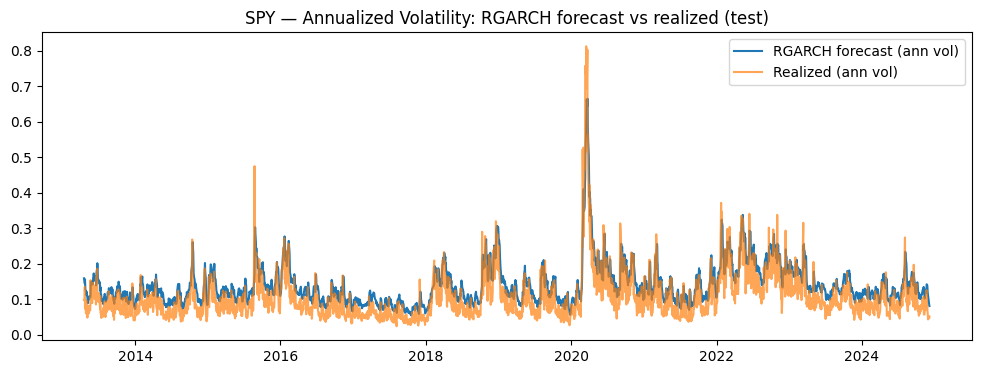

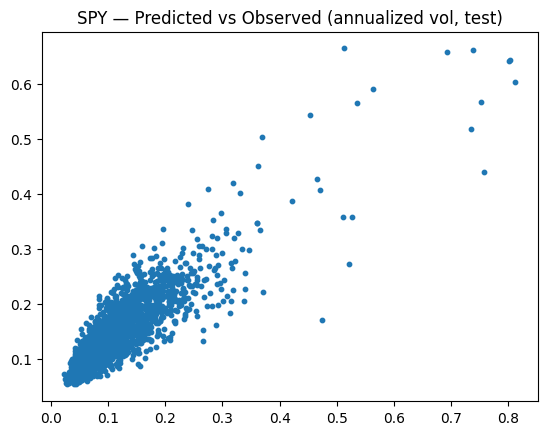

In [ ]:
# plots

gspy = rg_oos[(rg_oos["ticker"]=="SPY") & (rg_oos["set"]=="test")].copy()
plt.figure(figsize=(12,4))
plt.plot(gspy["Date"], gspy["sigma_fore1_ann"], label="RGARCH forecast (ann vol)")
plt.plot(gspy["Date"], gspy["vol_ann"], label="Realized (ann vol)", alpha=0.7)
plt.title("SPY — Annualized Volatility: RGARCH forecast vs realized (test)")
plt.legend(); plt.show()

plt.scatter(gspy["vol_ann"], gspy["sigma_fore1_ann"], s=10)
plt.title("SPY — Predicted vs Observed (annualized vol, test)"); plt.show()
